# Dosed Training and Evaluation

You need the data for training as memmaps, to get them you either:
  - Go through `download_and_data_format_explanation.ipynb`

or 

  - Run `bash ./minimum_example/download_and_format_data.sh`

In [1]:
import sys
sys.path.append("../")

from settings import MINIMUM_EXAMPLE_SETTINGS as settings
import os
import json

# Retrieve index of memmaps containing all the informations regarding training data
data_index_filename = settings["memmap_directory"] + "index.json"
data_index = json.load(open(data_index_filename, "r"))

# 1. Train, validation and test dataset creation

## First we select which records we want to train, validate and test on

In [2]:
import torch
import tempfile
import json
import random


from dosed.preprocessings import RescaleNormal, Invert, GaussianNoise
from dosed.utils import Compose
from dosed.datasets import BalancedEventDataset as dataset
from dosed.models import DOSED3 as model
from dosed.trainers import trainers

In [3]:
records = data_index["records"]
random.seed(2019)
random.shuffle(records)
print("Number of records:", len(records))

Number of records: 21


In [4]:
# We take 11 records for training, 5 for validation and 5 for test.
records_train = records[:11]
records_validation = records[11:16]
records_test = records[16:]

## Then we use the dataset class that will be use to generate sample for training and evaluation

- window: Spindles have a duration of ~1 seconds, so we design the samples accordingly by choosing 10 seconds windows
- ratio_positive: sample within a training batch will have a probability of "ratio_positive" to contain at least one spindle 


In [5]:
window = 10  # window duration in seconds
ratio_positive = 0.5  # When creating the batch, sample containing at least one spindle will be drawn with that probability
downsampling = 2

In [6]:
dataset_parameters = {
    "data_index_filename": data_index_filename,
    "window": window,
    "ratio_positive": ratio_positive,
    "downsampling": downsampling,
}

dataset_validation = dataset(records=records_validation, **dataset_parameters)
dataset_test = dataset(records=records_test, **dataset_parameters)

# for training add data augmentation
dataset_parameters_train = {
    "transformations": Compose([
        GaussianNoise(),
        RescaleNormal(),
        Invert(),
    ])
}
dataset_parameters_train.update(dataset_parameters)
dataset_train = dataset(records=records_train, **dataset_parameters_train)

# 2. Create a network

The main parameters for the network are:
  - default event sizes : to choose according to a priori size of the event to detect, here spindles are around 1 second
  - k_max : number of CNN layers
  

In [7]:
default_event_sizes = [0.7, 1, 1.3]
k_max = 5
kernel_size = 5
probability_dropout = 0.1
device = torch.device("cuda")

In [8]:
fs = data_index["signals"]["fs"]

net_parameters = {
    "detection_parameters": {
        "overlap_non_maximum_suppression": 0.5,
        "classification_threshold": 0.7
    },
    "default_event_sizes": [
        default_event_size * fs
        for default_event_size in default_event_sizes
    ],
    "k_max": k_max,
    "kernel_size": kernel_size,
    "pdrop": probability_dropout,
    "downsampling": downsampling,
    "fs": fs,
    "input_size": (dataset_train.input_size, dataset_train.number_of_channels),
    "number_of_classes": dataset_train.number_of_classes,
}
net = model(**net_parameters)
net = net.to(device)


Input feature map size: 320
Input receptive field: 0
Input size in seconds: 10.0 s
Input receptive field in seconds: 0.0 s 

After layer 1:
	Feature map size: 160
	Receptive field: 6
	Receptive field in seconds: 0.1875 s
After layer 2:
	Feature map size: 80
	Receptive field: 16
	Receptive field in seconds: 0.5 s
After layer 3:
	Feature map size: 40
	Receptive field: 36
	Receptive field in seconds: 1.125 s
After layer 4:
	Feature map size: 20
	Receptive field: 76
	Receptive field in seconds: 2.375 s
After layer 5:
	Feature map size: 10
	Receptive field: 156
	Receptive field in seconds: 4.875 s




# 3. Train the network

Parameters are
  - learning_rate
  - loss type

In [9]:
optimizer_parameters = {
    "lr": 5e-3,
    "weight_decay": 1e-8,
}
loss_specs = {
    "type": "worst_negative_mining",
    "parameters": {
        "number_of_classes": dataset_train.number_of_classes,
        "device": device,
    }
}
epochs = 100

In [10]:
trainer = trainers["adam"](
    net,
    optimizer_parameters=optimizer_parameters,
    loss_specs=loss_specs,
    epochs=epochs,
)

best_net_train, best_metrics_train, best_threshold_train = trainer.train(
    dataset_train,
    dataset_validation,
)

  0%|          | 0/100 [00:00<?, ?it/s]

Device:  0
Logging data to ./logs/train_history.json


/home/valentin/.virtualenvs/python3/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 100/100 [5:00:55<00:00, 175.17s/it, best_metric_score=0.561, last_update=88, threshold=0.832]


In [11]:
predictions = best_net_train.predict_dataset(
    dataset_test,
    best_threshold_train,
)

# 4. Predict

In [13]:
predictions = best_net_train.predict_dataset(
    dataset_test,
    best_threshold_train,
)

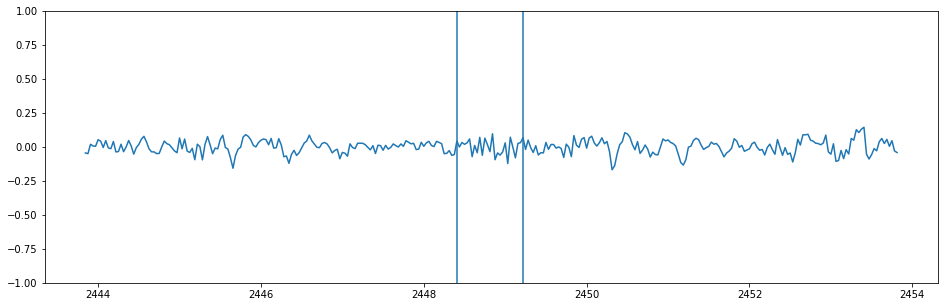

In [80]:
import matplotlib.pyplot as plt
import numpy as np

record = dataset_test.records[1]

index_spindle = 19
window_duration = 5
frequency = 32

# retrive spindle at the right index
spindle_start = float(predictions[record][0][index_spindle][0]) / frequency
spindle_end = float(predictions[record][0][index_spindle][1]) / frequency

# center data window on annotated spindle 
start_window = spindle_start + (spindle_end - spindle_start) / 2 - window_duration
stop_window = spindle_start + (spindle_end - spindle_start) / 2 + window_duration

# Retrieve EEG data at right index
index_start = int(start_window * frequency)
index_stop = int(stop_window * frequency)
y = dataset_test.signals[record]["data"][0][index_start:index_stop]

# Build corresponding time support
t = start_window + np.cumsum(np.ones(index_stop - index_start) * 1 / frequency)

plt.figure(figsize=(16, 5))
plt.plot(t, y)
plt.axvline(spindle_end)
plt.axvline(spindle_start)
plt.ylim([-1, 1])
plt.show()